In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

RSEED=42


import airportsdata

# Loading data + Info

|column|description|
|---|---|
|DATOP | Date of flight|
|FLTID | Flight number|
|DEPSTN | Departure point|
|ARRSTN | Arrival point|
|STD | Scheduled Time departure|
|STA | Scheduled Time arrival|
STATUS | Flight status|
|ETD | Expected Time departure|
|ETA | Expected Time arrival|
|ATD | Actual Time of Departure|
|ATA | Actual Time of arrival|
|DELAY1 | Delay code 1|
|DUR1 | delay time 1|
|DELAY2 | Delay code 2|
|DUR2 | delay time 2|
|DELAY3 | Delay code 3|
|DUR3 | delay time 3|
|DELAY4 | Delay code 4|
|DUR4 | delay time 4|
|AC | Aircraft Code|



In [2]:
df_train = pd.read_csv("data/Train.csv")
df_test = pd.read_csv("data/Test.csv")
SampleSubmission = pd.read_csv("data/SampleSubmission.csv")
airports= airportsdata.load()


In [3]:
#airports["KJFK"]["name"]

In [4]:
# loading airport data into separate df for EDA (otherwise too large), combining with 

air= pd.DataFrame(airports).T.reset_index()
air

load_data = pd.DataFrame(airportsdata.load('IATA'))
airport_data = load_data.T.reset_index()
df_new = df_train.merge(airport_data, how= 'left', left_on ='DEPSTN', right_on ='index').merge(airport_data, how= 'left', left_on='ARRSTN', right_on='index')
df_new.columns = df_new.columns.str.replace('_x', '_dep').str.replace('_y', '_arr')

In [5]:
df_new.shape

(107833, 32)

In [6]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107833 entries, 0 to 107832
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             107833 non-null  object 
 1   DATOP          107833 non-null  object 
 2   FLTID          107833 non-null  object 
 3   DEPSTN         107833 non-null  object 
 4   ARRSTN         107833 non-null  object 
 5   STD            107833 non-null  object 
 6   STA            107833 non-null  object 
 7   STATUS         107833 non-null  object 
 8   AC             107833 non-null  object 
 9   target         107833 non-null  float64
 10  index_dep      107501 non-null  object 
 11  icao_dep       107501 non-null  object 
 12  iata_dep       107501 non-null  object 
 13  name_dep       107501 non-null  object 
 14  city_dep       107501 non-null  object 
 15  subd_dep       107501 non-null  object 
 16  country_dep    107501 non-null  object 
 17  elevation_dep  107501 non-nul

In [7]:
print(df_train.shape, df_test.shape, SampleSubmission.shape, df_new.shape)

(107833, 10) (9333, 9) (9333, 2) (107833, 32)


In [8]:
df_new.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'index_dep', 'icao_dep', 'iata_dep', 'name_dep',
       'city_dep', 'subd_dep', 'country_dep', 'elevation_dep', 'lat_dep',
       'lon_dep', 'tz_dep', 'index_arr', 'icao_arr', 'iata_arr', 'name_arr',
       'city_arr', 'subd_arr', 'country_arr', 'elevation_arr', 'lat_arr',
       'lon_arr', 'tz_arr'],
      dtype='object')

In [9]:
df_train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


In [10]:
df_train.tail()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0
107832,train_id_107832,2018-11-13,UG 0002,TUN,DJE,2018-11-13 06:15:00,2018-11-13 07.05.00,SCH,TU CR9ISA,0.0


In [11]:
df_new.describe()

,target
count,107833.000000
mean,48.733013
std,117.135562
min,0.000000
25%,0.000000
50%,14.000000
75%,43.000000
max,3451.000000


In [12]:
print(df_new["STATUS"].nunique(),df_new["STATUS"].unique())

5 ['ATA' 'DEP' 'RTR' 'SCH' 'DEL']


In [13]:
print(df_new.head())

           ID       DATOP     FLTID DEPSTN ARRSTN                  STD  \
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00   
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   

                   STA STATUS         AC  target  ... icao_arr iata_arr  \
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0  ...     DTTA      TUN   
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0  ...     DTTA      TUN   
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0  ...     LTFM      IST   
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0  ...     LFRS      NTE   
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0  ...     DAAG      ALG   

                               name_arr  city_arr          subd_arr  \
0  Tunis Carthage International A

# Data cleaning

In [14]:
# convert STD and STA into datetime objects
df_new["STD"]=df_new["STD"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_new["STA"]=df_new["STA"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H.%M.%S'))
#df_new.STD.iloc[1].day

In [15]:
df_new[["STA","STD"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107833 entries, 0 to 107832
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   STA     107833 non-null  datetime64[ns]
 1   STD     107833 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 2.5 MB


In [16]:
# create new column with duration

df_new["sch_duration"]=(df_new.STA - df_new.STD)/timedelta(minutes=1)
print(df_new[["STA","STD","sch_duration"]].info())
print(df_new[["STA","STD","sch_duration"]].head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107833 entries, 0 to 107832
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   STA           107833 non-null  datetime64[ns]
 1   STD           107833 non-null  datetime64[ns]
 2   sch_duration  107833 non-null  float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 3.3 MB
None
                  STA                 STD  sch_duration
0 2016-01-03 12:55:00 2016-01-03 10:30:00         145.0
1 2016-01-13 16:55:00 2016-01-13 15:05:00         110.0
2 2016-01-16 06:45:00 2016-01-16 04:10:00         155.0
3 2016-01-17 17:00:00 2016-01-17 14:10:00         170.0
4 2016-01-17 15:50:00 2016-01-17 14:30:00          80.0


In [17]:
# crating integer columns out of datetime objects for usage in EDA and ML

df_new['year'] = df_new['STD'].apply(lambda x: x.year).apply(pd.to_numeric)
df_new['dep_hour'] = df_new['STD'].apply(lambda x: x.hour).apply(pd.to_numeric)
df_new['arr_hour'] = df_new['STA'].apply(lambda x: x.hour).apply(pd.to_numeric)
df_new['dep_month'] = df_new['STD'].apply(lambda x: x.month).apply(pd.to_numeric)
df_new['arr_month'] = df_new['STA'].apply(lambda x: x.month).apply(pd.to_numeric)

In [18]:
# creating additional date columns

#df_new['year'] = df_new['STD'].apply(lambda x: datetime.strftime(x,'%Y'))

df_new['dep_date'] = df_new['STD'].apply(lambda x: datetime.strftime(x,'%m-%d'))
df_new['dep_time'] = df_new['STD'].apply(lambda x: datetime.strftime(x,'%H:%M:%S'))

df_new['arr_date'] = df_new['STA'].apply(lambda x: datetime.strftime(x,'%m-%d'))
df_new['arr_time'] = df_new['STA'].apply(lambda x: datetime.strftime(x,'%H:%M:%S'))

#df_new['sch_duration'] = ((df_new['STA'] -df_new['STD'])/timedelta(minutes=1))
#df_new['duration'] = ((df_new['STA'] -df_new['STD'])/timedelta(minutes=1)) + df_new['target']

In [19]:
# drop old STA and STD columns

df_new.drop(["STD","STA"], axis=1, inplace=True)

In [20]:
# remove SFX airport rows

df_new = df_new.query('DEPSTN != "SXF" and ARRSTN != "SXF"')
df_new.drop(["index_dep","index_arr"], axis=1, inplace=True)
df_new.shape

(107172, 38)

In [21]:
df_new.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STATUS', 'AC', 'target',
       'icao_dep', 'iata_dep', 'name_dep', 'city_dep', 'subd_dep',
       'country_dep', 'elevation_dep', 'lat_dep', 'lon_dep', 'tz_dep',
       'icao_arr', 'iata_arr', 'name_arr', 'city_arr', 'subd_arr',
       'country_arr', 'elevation_arr', 'lat_arr', 'lon_arr', 'tz_arr',
       'sch_duration', 'year', 'dep_hour', 'arr_hour', 'dep_month',
       'arr_month', 'dep_date', 'dep_time', 'arr_date', 'arr_time'],
      dtype='object')

In [22]:
# convert columns to numeric

df_new[["elevation_arr","elevation_dep","lat_arr","lon_arr","lat_dep","lon_dep"]]=df_new[["elevation_arr","elevation_dep","lat_arr","lon_arr","lat_dep","lon_dep"]].apply(pd.to_numeric)
df_new.head(2)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STATUS,AC,target,icao_dep,iata_dep,...,sch_duration,year,dep_hour,arr_hour,dep_month,arr_month,dep_date,dep_time,arr_date,arr_time
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,ATA,TU 32AIMN,260.0,GMMN,CMN,...,145.0,2016,10,12,1,1,01-03,10:30:00,01-03,12:55:00
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,ATA,TU 31BIMO,20.0,LIMC,MXP,...,110.0,2016,15,16,1,1,01-13,15:05:00,01-13,16:55:00


In [23]:
# creating new column with distances between arrival and departure airport

distances = pd.read_csv('data/distance.csv')
df_new = df_new.merge(distances, on='ID')
df_new.drop(["Unnamed: 0"], axis=1, inplace=True)

In [24]:
df_new

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STATUS,AC,target,icao_dep,iata_dep,...,year,dep_hour,arr_hour,dep_month,arr_month,dep_date,dep_time,arr_date,arr_time,trav_dist
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,ATA,TU 32AIMN,260.0,GMMN,CMN,...,2016,10,12,1,1,01-03,10:30:00,01-03,12:55:00,1666.949101
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,ATA,TU 31BIMO,20.0,LIMC,MXP,...,2016,15,16,1,1,01-13,15:05:00,01-13,16:55:00,983.064595
2,train_id_2,2016-01-16,TU 0214,TUN,IST,ATA,TU 32AIMN,0.0,DTTA,TUN,...,2016,4,6,1,1,01-16,04:10:00,01-16,06:45:00,1673.053088
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,ATA,TU 736IOK,0.0,DTTJ,DJE,...,2016,14,17,1,1,01-17,14:10:00,01-17,17:00:00,1805.107067
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,ATA,TU 320IMU,22.0,DTTA,TUN,...,2016,14,15,1,1,01-17,14:30:00,01-17,15:50:00,626.108971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107167,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,SCH,TU 32AIML,0.0,DTTA,TUN,...,2018,23,2,7,7,07-05,23:00:00,07-06,02:00:00,0.000000
107168,train_id_107829,2018-01-13,UG 0003,DJE,TUN,SCH,UG AT7AT7,0.0,DTTJ,DJE,...,2018,8,9,1,1,01-13,08:00:00,01-13,09:00:00,333.916459
107169,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,SCH,TU 736IOK,0.0,DTTA,TUN,...,2018,5,12,11,11,11-07,05:00:00,11-07,12:50:00,0.000000
107170,train_id_107831,2018-01-23,UG 0010,TUN,DJE,ATA,TU CR9ISA,0.0,DTTA,TUN,...,2018,18,18,1,1,01-23,18:00:00,01-23,18:45:00,333.916459


In [25]:
# further column drops
df_new.drop(["DATOP","icao_arr","iata_arr","icao_dep","iata_dep","name_dep","name_dep"], axis=1, inplace=True)
df_new.drop(["ID"], axis=1, inplace=True)
df_new.drop(["dep_date","dep_time","arr_date","arr_time"], axis=1, inplace=True)



# Looking at data

<AxesSubplot:xlabel='target', ylabel='Count'>

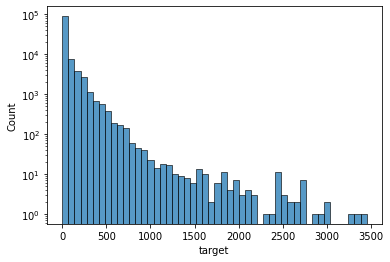

In [26]:
# Display distribution of target

#plt.ylim(0,2000)
#plt.xlim(0,500)
plt.semilogy(base=10)
sns.histplot(data=df_train, x="target",bins=50)

In [27]:

fig=px.histogram(df_new, x="target",log_y=True, hover_name="year")
fig.show()

<AxesSubplot:xlabel='arr_hour', ylabel='count'>

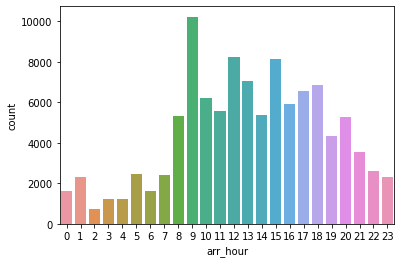

In [28]:
#plt.ylim(0,2000)
#plt.xlim(0,500)
#plt.semilogy(base=10)mont
sns.countplot(data=df_new, x="arr_hour")

In [29]:
cat_features=list(df_new.columns[df_new.dtypes==object])
cat_features

['FLTID',
 'DEPSTN',
 'ARRSTN',
 'STATUS',
 'AC',
 'city_dep',
 'subd_dep',
 'country_dep',
 'tz_dep',
 'name_arr',
 'city_arr',
 'subd_arr',
 'country_arr',
 'tz_arr']

In [30]:
# how many categories per categorical feature

df_new[cat_features].nunique()

FLTID          1857
DEPSTN          131
ARRSTN          127
STATUS            5
AC               68
city_dep        126
subd_dep        115
country_dep      54
tz_dep           56
name_arr        127
city_arr        122
subd_arr        110
country_arr      51
tz_arr           53
dtype: int64

In [31]:
num_features=list(df_new.columns[df_new.dtypes!=object])
num_features

['target',
 'elevation_dep',
 'lat_dep',
 'lon_dep',
 'elevation_arr',
 'lat_arr',
 'lon_arr',
 'sch_duration',
 'year',
 'dep_hour',
 'arr_hour',
 'dep_month',
 'arr_month',
 'trav_dist']

In [32]:
df_new.shape

(107172, 28)

In [33]:
df_new.columns

Index(['FLTID', 'DEPSTN', 'ARRSTN', 'STATUS', 'AC', 'target', 'city_dep',
       'subd_dep', 'country_dep', 'elevation_dep', 'lat_dep', 'lon_dep',
       'tz_dep', 'name_arr', 'city_arr', 'subd_arr', 'country_arr',
       'elevation_arr', 'lat_arr', 'lon_arr', 'tz_arr', 'sch_duration', 'year',
       'dep_hour', 'arr_hour', 'dep_month', 'arr_month', 'trav_dist'],
      dtype='object')

In [34]:
list1=df_new.columns[1:13].tolist()
list2=df_new.columns[14:26].tolist()
list3=df_new.columns[26:29].tolist()

print(len(list1), len(list2))
print(list1,list2,list3)


12 12
['DEPSTN', 'ARRSTN', 'STATUS', 'AC', 'target', 'city_dep', 'subd_dep', 'country_dep', 'elevation_dep', 'lat_dep', 'lon_dep', 'tz_dep'] ['city_arr', 'subd_arr', 'country_arr', 'elevation_arr', 'lat_arr', 'lon_arr', 'tz_arr', 'sch_duration', 'year', 'dep_hour', 'arr_hour', 'dep_month'] ['arr_month', 'trav_dist']


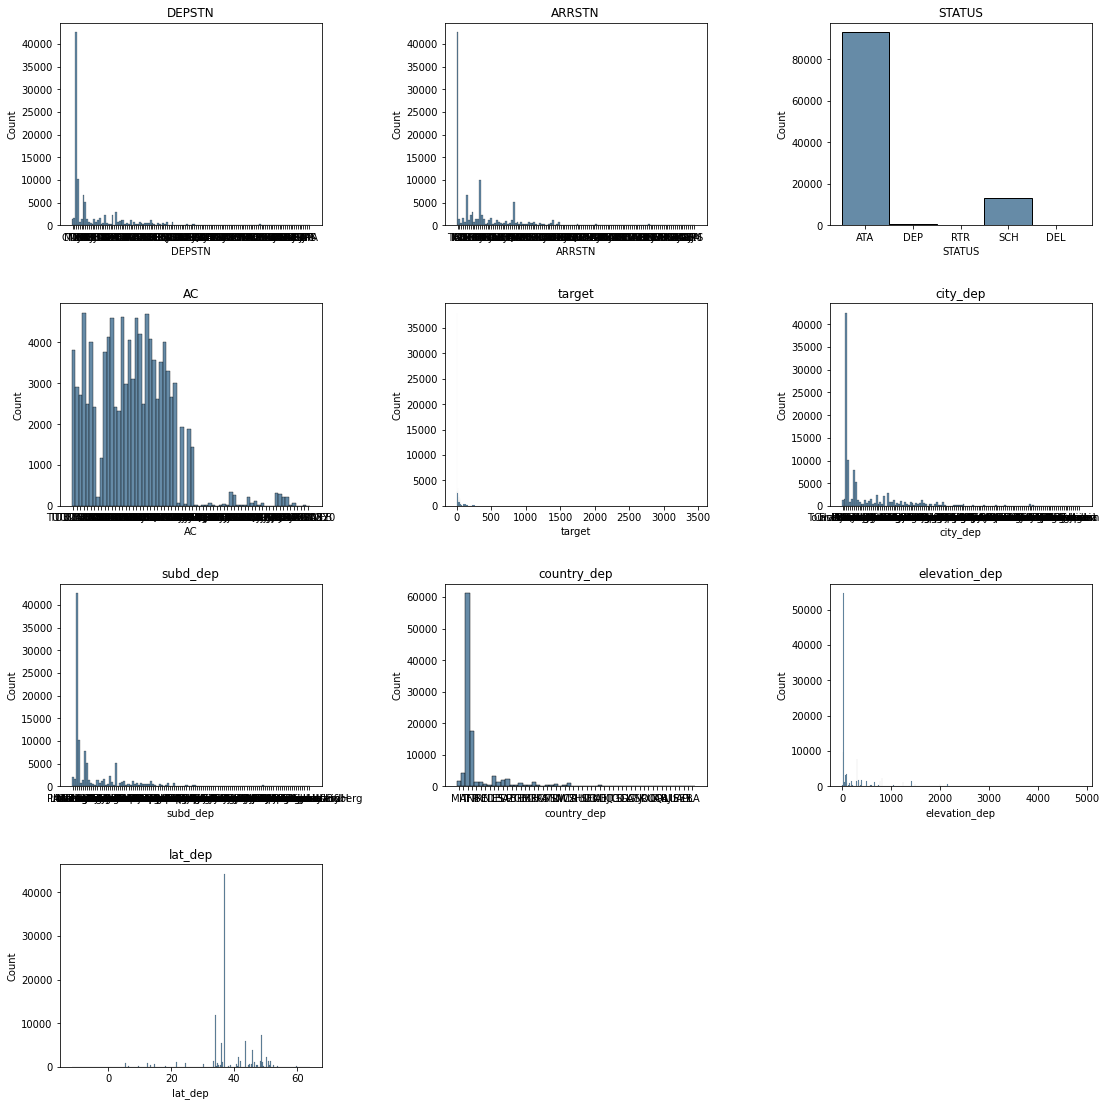

In [35]:
# Outliers
fig,ax = plt.subplots(4,3, figsize=(16,16))
count = 0
for item in df_new[list1].columns.tolist():
    sns.histplot(df_new[item], kde=False, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item)
    
    count += 1
ax.flat[-2].set_visible(False)

ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

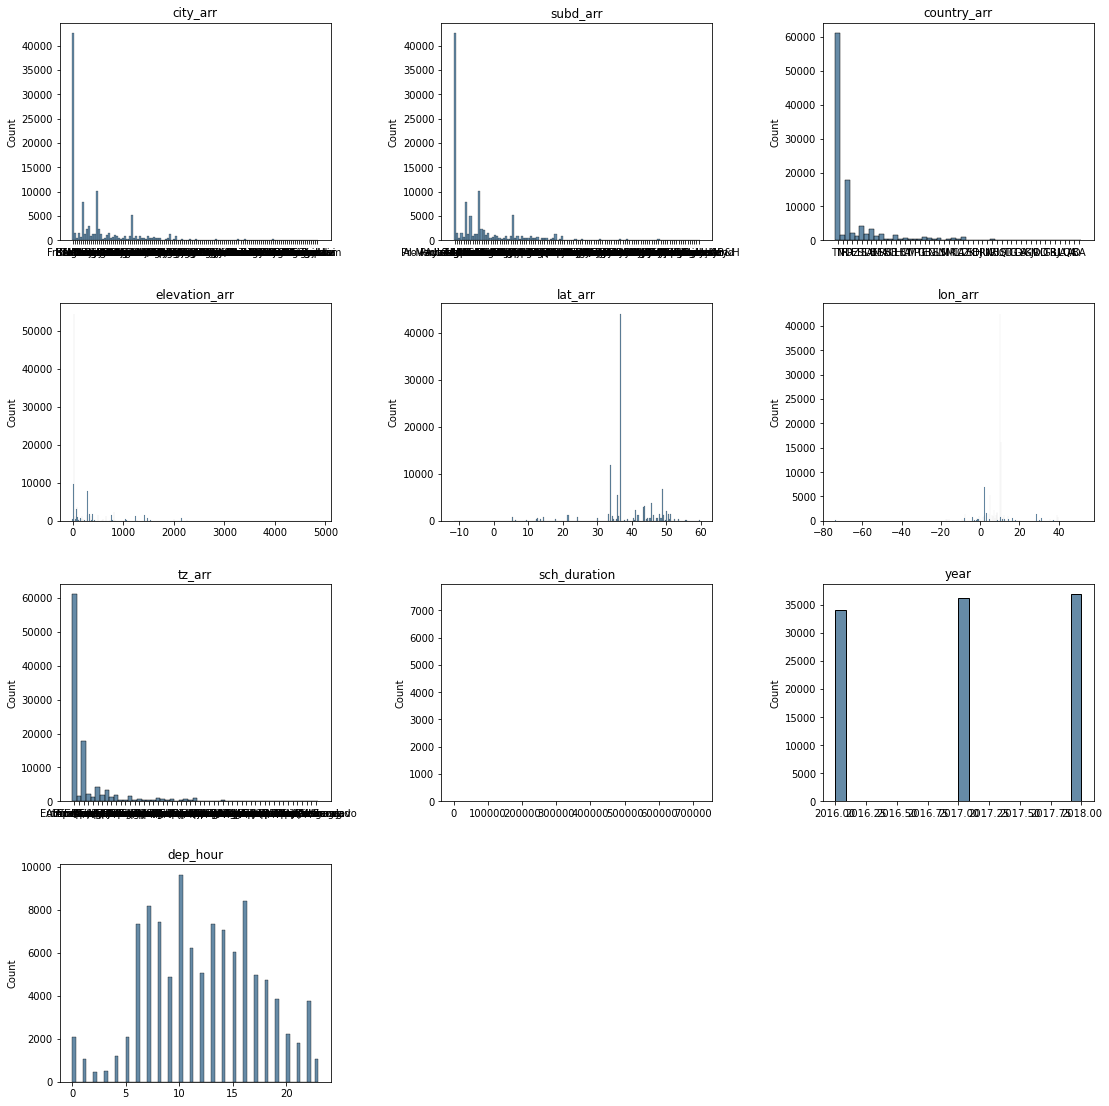

In [36]:
# Outliers
#fig,ax = plt.subplots(4,3, figsize=(16,16))
#count = 0
#for item in df_new[list2].columns.tolist():
#    sns.histplot(df_new[item], kde=False, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
#    count += 1
#ax.flat[-2].set_visible(False)

#ax.flat[-1].set_visible(False)
#fig.tight_layout(pad=3)

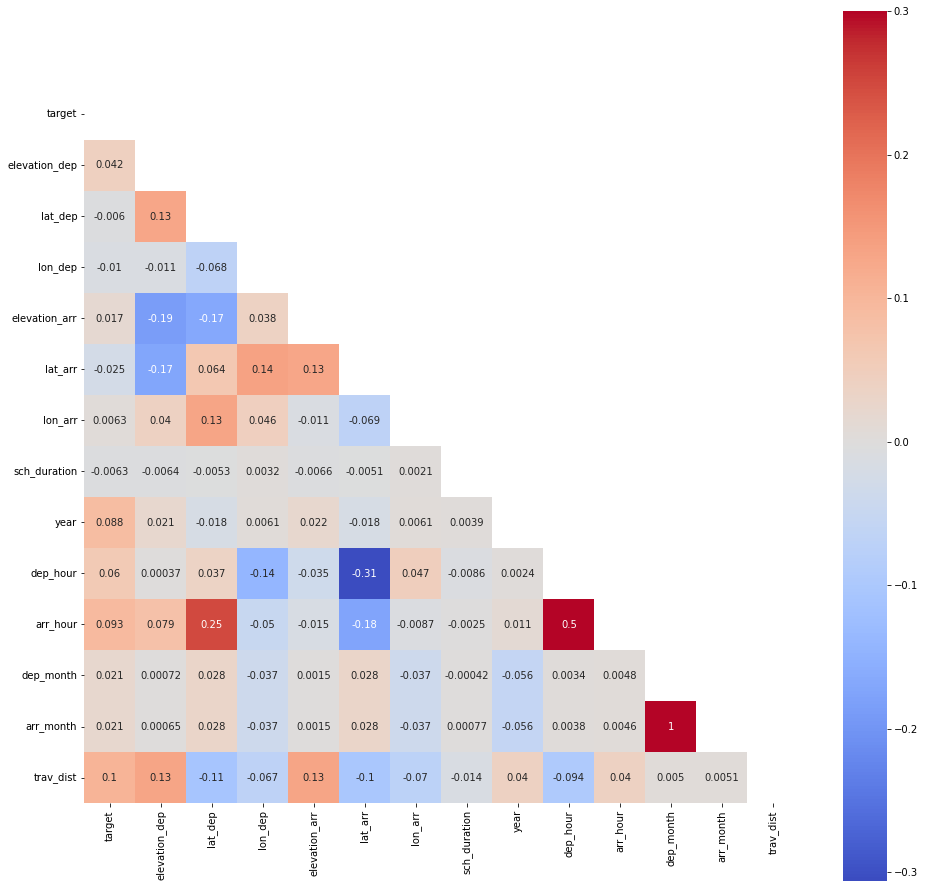

In [37]:
corr = df_new.corr()
#print(corr.round(2))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
cmap = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(16,16))
sns.heatmap(corr, mask=mask, vmax=.3, cmap=cmap, square=True,annot=True);

<AxesSubplot:xlabel='STATUS', ylabel='target'>

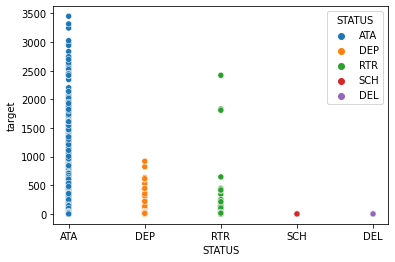

In [38]:
sns.scatterplot(data=df_new, x="STATUS", y="target",hue="STATUS")

<AxesSubplot:xlabel='arr_hour', ylabel='target'>

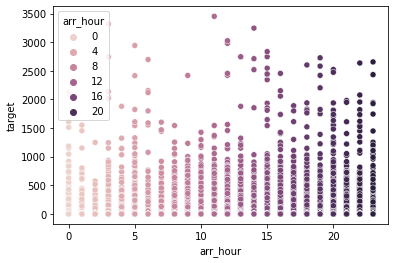

In [39]:
sns.scatterplot(data=df_new, x="arr_hour", y="target",hue="arr_hour")

<AxesSubplot:xlabel='arr_month', ylabel='target'>

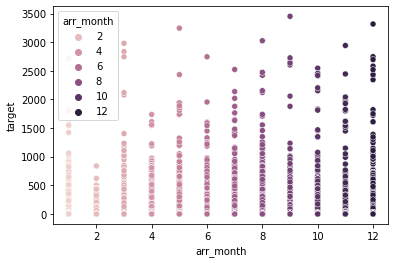

In [40]:
sns.scatterplot(data=df_new, x="arr_month", y="target",hue="arr_month")

<AxesSubplot:xlabel='trav_dist', ylabel='target'>

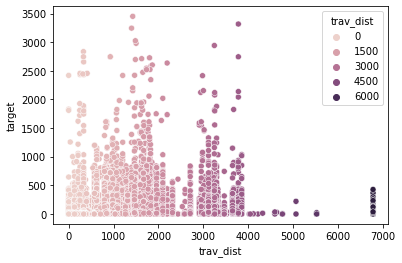

In [41]:
sns.scatterplot(data=df_new, x="trav_dist", y="target",hue="trav_dist")

<AxesSubplot:xlabel='sch_duration', ylabel='target'>

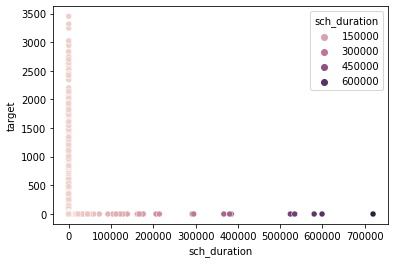

In [42]:
sns.scatterplot(data=df_new, x="sch_duration", y="target",hue="sch_duration")

<AxesSubplot:xlabel='tz_arr', ylabel='Count'>

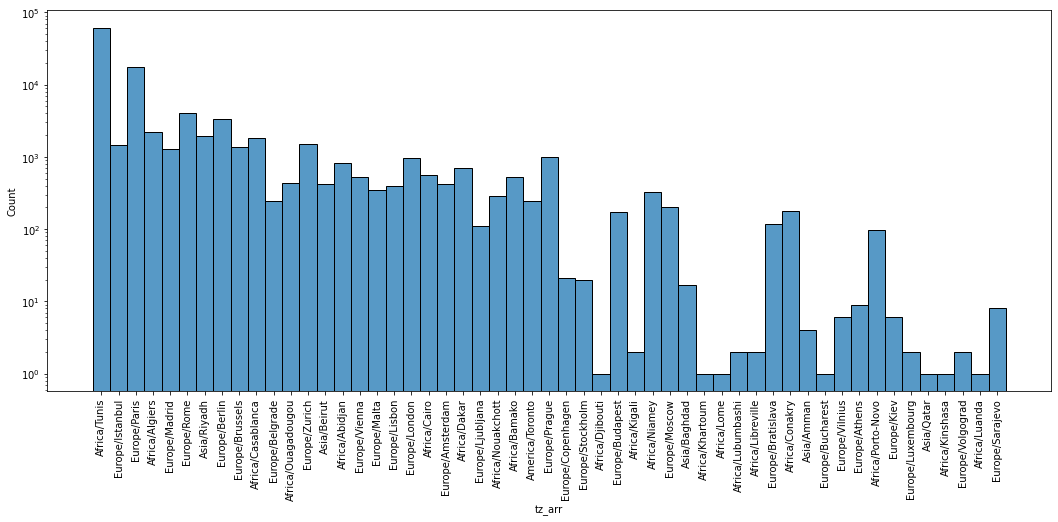

In [47]:
plt.figure(figsize=(18,7))
plt.yscale("log")
plt.xticks(rotation=90)
#sns.histplot(data=df_new, x="city_arr")
sns.histplot(data=df_new, x="tz_arr")

# Baseline model

<AxesSubplot:xlabel='target', ylabel='arr_month'>

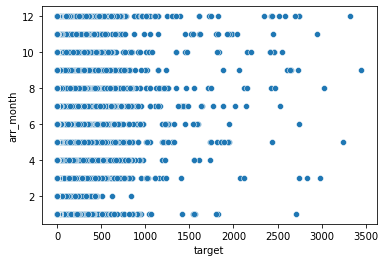

In [44]:
sns.scatterplot(data=df_new, y="arr_month", x="target")

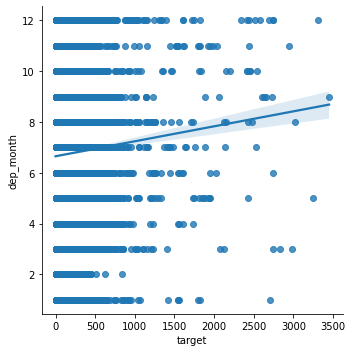

In [56]:
sns.lmplot(data=df_new, x="target", y="dep_month")

In [45]:
df_new.query("dep_month != arr_month")

,FLTID,DEPSTN,ARRSTN,STATUS,AC,target,city_dep,subd_dep,country_dep,elevation_dep,...,lat_arr,lon_arr,tz_arr,sch_duration,year,dep_hour,arr_hour,dep_month,arr_month,trav_dist
126,TU 0398,ABJ,TUN,ATA,TU 320IMW,170.0,Abidjan,Lagunes,CI,21.0,...,36.851002,10.227200,Africa/Tunis,315.0,2016,22,3,6,7,3784.130856
315,TU 6058,JED,TUN,ATA,TU 320IMU,10.0,Jeddah,Makkah,SA,48.0,...,36.851002,10.227200,Africa/Tunis,300.0,2016,21,2,4,5,3256.052105
388,TU 0913,TUN,MED,ATA,TU 320IMS,23.0,Tunis,Tunis,TN,22.0,...,24.553400,39.705101,Asia/Riyadh,260.0,2016,19,0,2,3,3118.267129
1676,TU 0215,IST,TUN,ATA,TU 32AIMN,0.0,Istanbul,Istanbul,TR,325.0,...,36.851002,10.227200,Africa/Tunis,170.0,2016,23,2,4,5,1673.053088
2087,TU 0613,TUN,DKR,ATA,TU 320IMR,19.0,Tunis,Tunis,TN,22.0,...,14.739700,-17.490200,Africa/Dakar,315.0,2016,19,0,1,2,3678.974557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106955,WKL 0000,TUN,TUN,SCH,TU 31BIMQ,0.0,Tunis,Tunis,TN,22.0,...,36.851002,10.227200,Africa/Tunis,180.0,2018,22,1,4,5,0.000000
106978,AOG 0000,TUN,TUN,SCH,TU 320IMS,0.0,Tunis,Tunis,TN,22.0,...,36.851002,10.227200,Africa/Tunis,5565.0,2018,11,7,4,5,0.000000
107050,AOG 0000,TUN,TUN,SCH,TU 32AIMI,0.0,Tunis,Tunis,TN,22.0,...,36.851002,10.227200,Africa/Tunis,1920.0,2018,18,2,12,1,0.000000
107115,WKL 0000,MIR,MIR,SCH,TU 736IOM,0.0,Monastir,Al-Munastir,TN,9.0,...,35.758099,10.754700,Africa/Tunis,180.0,2018,22,1,12,1,0.000000


In [58]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X= df_new[["dep_month"]]
y= df_new["target"]

lin = LinearRegression()
lin.fit(X,y)

intercept = lin.intercept_
coef = lin.coef_
print(intercept.round(2), coef.round(2))

y_pred = lin.predict(X)
rms= mean_squared_error(y,y_pred, squared=False)
print("RMSE: ", rms.round(2))

43.76 [0.74]
RMSE:  116.56


# Regression Model